In [15]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
)
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D ,BatchNormalization, Flatten, Dropout
from tensorflow.keras import layers, models

import tensorflow as tf

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [4]:

# Copy the kaggle.json to the appropriate location
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riwaj111111","key":"4f87d63a52c5d0f05857576ffd2abe2e"}'}

In [5]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

In [6]:
!kaggle datasets download fpeccia/weed-detection-in-soybean-crops -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/fpeccia/weed-detection-in-soybean-crops
License(s): other
100% 2.36G/2.37G [02:01<00:00, 18.5MB/s]
100% 2.37G/2.37G [02:01<00:00, 20.9MB/s]


In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
original_data_dir = "/content/dataset/dataset/"
output_base_dir = "/content/splitted_dataset/"

# Paths for train, validation, and test splits
train_dir = os.path.join(output_base_dir, "train")
valid_dir = os.path.join(output_base_dir, "validation")
test_dir = os.path.join(output_base_dir, "test")

# Create directories for train, validation, and test splits
for split_dir in [train_dir, valid_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Get list of class subdirectories
classes = [d for d in os.listdir(original_data_dir) if os.path.isdir(os.path.join(original_data_dir, d))]

for class_name in classes:
    # Paths for the current class
    class_dir = os.path.join(original_data_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    valid_class_dir = os.path.join(valid_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    # Create class subdirectories
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(valid_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # List all images in the class directory
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Split into train, validation, and test
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    train_imgs, valid_imgs = train_test_split(train_imgs, test_size=0.125, random_state=42)  # 10% of train+valid

    # Move files to respective directories
    for img in train_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_class_dir, img))
    for img in valid_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(valid_class_dir, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_class_dir, img))

print("Dataset split complete!")

Dataset split complete!


In [16]:
train_dir = "/content/splitted_dataset/train/"
test_dir = "/content/splitted_dataset/test/"
valid_dir = "/content/splitted_dataset/validation/"

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
image_shape = (224, 224)  # Resize all images to 224x224
batch_size = 64  # Batch size for loading data

# Initialize ImageDataGenerator for training/validation and test
train_valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    validation_split=0.125  # 10% out of the 80% data for validation (10/80 = 0.125)
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only rescaling for test data

# Create training data generator (70% of the total dataset)
print("Training Images:")
train_data = train_valid_datagen.flow_from_directory(
    train_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Specify training subset (70% of total)
)

# Create validation data generator (10% of the total dataset)
print("Validating Images:")
valid_data = train_valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # Specify validation subset (10% of total)
)

# Create test data generator (20% of the total dataset)
print("Test Images:")
test_data = test_datagen.flow_from_directory(
   test_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Training Images:
Found 9392 images belonging to 4 classes.
Validating Images:
Found 190 images belonging to 4 classes.
Test Images:
Found 3069 images belonging to 4 classes.


In [18]:

# Extract class names from the datasets using class_indices
train_class_names = list(train_data.class_indices.keys())
valid_class_names = list(valid_data.class_indices.keys())
test_class_names = list(test_data.class_indices.keys())

# Print class names
print("Training Class Names:", train_class_names)
print("Validation Class Names:", valid_class_names)
print("Test Class Names:", test_class_names)

# Print the number of classes
print("Number of Training Classes:", len(train_class_names))
print("Number of Validation Classes:", len(valid_class_names))
print("Number of Test Classes:", len(test_class_names))

Training Class Names: ['broadleaf', 'grass', 'soil', 'soybean']
Validation Class Names: ['broadleaf', 'grass', 'soil', 'soybean']
Test Class Names: ['broadleaf', 'grass', 'soil', 'soybean']
Number of Training Classes: 4
Number of Validation Classes: 4
Number of Test Classes: 4


In [19]:
class_names = train_class_names


In [23]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import InputLayer

model = Sequential()
model.add(InputLayer(input_shape=(224,224,3)))
model.add(Conv2D(16,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
#model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,330,196 (5.07 MB)

 Trainable params: 1,330,196 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


In [26]:
# 13. Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7
)

# 14. Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

In [27]:

# 18. Fit the model (adjust epochs and batch size as needed)
history = model.fit(
    train_data,  # Replace with your training dataset
    validation_data=valid_data,  # Replace with your validation dataset
    epochs=25,
    batch_size=64,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 155s 954ms/step - accuracy: 0.6789 - loss: 0.7764 - val_accuracy: 0.8211 - val_loss: 0.4287 - learning_rate: 0.0010
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 187s 899ms/step - accuracy: 0.8253 - loss: 0.4496 - val_accuracy: 0.8579 - val_loss: 0.4000 - learning_rate: 0.0010
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 140s 904ms/step - accuracy: 0.8440 - loss: 0.3966 - val_accuracy: 0.8211 - val_loss: 0.3879 - learning_rate: 0.0010
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 143s 911ms/step - accuracy: 0.8699 - loss: 0.3234 - val_accuracy: 0.9158 - val_loss: 0.2361 - learning_rate: 0.0010
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 145s 937ms/step - accuracy: 0.8927 - loss: 0.2713 - val_accuracy: 0.8789 - val_loss: 0.2677 - learning_rate: 0.0010
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 142s 914ms/step - accuracy: 0.9045 - loss: 0.2514 - val_accuracy: 0.9368 - val_loss: 0.1619 - learning_rate: 0.0010
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 139s 901ms/step - accuracy: 0.9180 

In [29]:
model.save("weed_detection.keras")

# Training and Evaluation


In [28]:

Y_pred = model.predict(test_data)
score = model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - accuracy: 0.8935 - loss: 0.2622
Test loss: 0.10829770565032959
Test accuracy: 0.9595959782600403


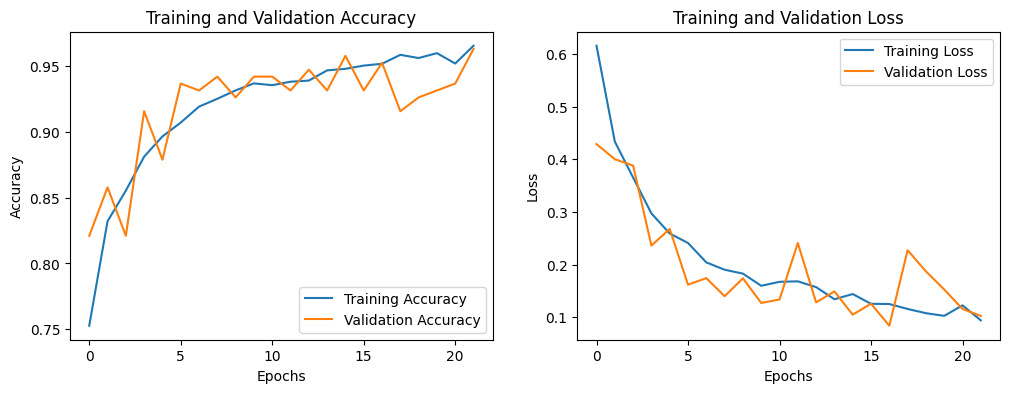

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

# Define class names (replace these with actual class names if available)
CLASS_NAMES = class_names

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Classification Report:
               precision    recall  f1-score   support

   broadleaf       0.83      0.71      0.77        14
       grass       0.88      0.95      0.91        44
        soil       1.00      1.00      1.00        40
     soybean       1.00      0.98      0.99        92

    accuracy                           0.96       190
   macro avg       0.93      0.91      0.92       190
weighted avg       0.96      0.96      0.96       190

Precision: 0.96, Recall: 0.96, F1 Score: 0.96


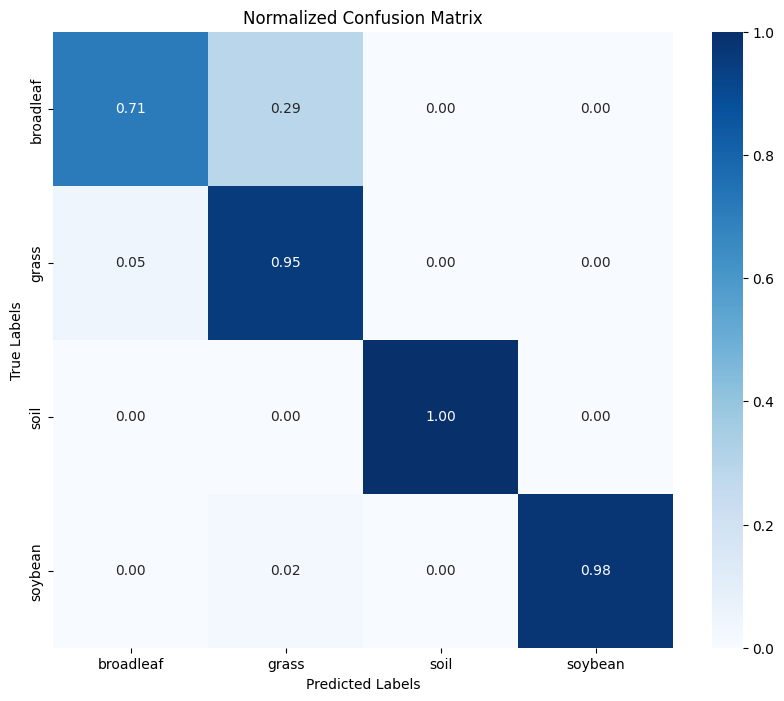

In [31]:

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Predict on validation data
Y_pred = model.predict(valid_data)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = valid_data.classes  # Actual class labels from validation data

# Generate a classification report
CLASS_NAMES = list(valid_data.class_indices.keys())  # Extract class names from validation data generator
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=class_names))

# Calculate precision, recall, and F1-score
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

# Calculate normalized confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# GUI Implementation


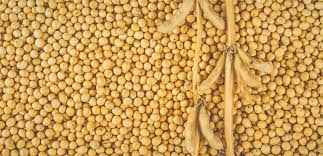

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [32]:
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import tensorflow as tf

# Load your pre-trained model
model = model  # Assuming your model is already loaded

# Define class names
CLASS_NAMES = class_names  # Use your actual class names here

# Function to preprocess and predict the image
def predict_image(img):
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict and get confidence score
    predictions = model.predict(img_array)
    confidence_scores = predictions[0]
    pred_index = np.argmax(confidence_scores)
    pred_class = class_names[pred_index]
    pred_confidence = confidence_scores[pred_index]

    result_label.value = f"Prediction: {pred_class}\nConfidence: {pred_confidence:.2f}"

# Define widgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
result_label = widgets.Label()

# Display the uploaded image and perform prediction
def on_upload_change(change):
    # Clear previous output (remove old image and result)
    clear_output(wait=True)

    # Re-display the upload button and result label
    display(widgets.VBox([upload_button, result_label]))

    for name, file_info in upload_button.value.items():
        image_data = io.BytesIO(file_info['content'])  # Convert binary content to a BytesIO object
        image = Image.open(image_data)  # Open image with PIL
        display(image)  # Display the uploaded image in the notebook
        predict_image(image)

upload_button.observe(on_upload_change, names='value')

# Display widgets
display(widgets.VBox([upload_button, result_label]))

In [33]:
class_names

['broadleaf', 'grass', 'soil', 'soybean']